# Milestone Project 2 - SkimLit

The purpose of this notebook is to build a NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset we'll be using) is available here: https://arxiv.org/pdf/1710.06071.pdf

And reading through the paper above, we'll see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/pdf/1612.05251.pdf

## Confirm access to a GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ecdd1ccf-87ed-5c7d-ebfc-8e51c20c6717)


## Get data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct


In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 10.23 MiB/s, done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check what files are in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# Start our experiments using 20k dataset with numbers replaces by '@' sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data

Now we've got some text data, it's time to become in with it. And one of the best ways to become one with the dataset is...

> Visualize, visualize, visualize

With that in mind, let's write a funciton to read in all of the lines of a target files.

In [ ]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (text filename) and returns the lines of text as a list.
  
  Args:
    filename: a string containing the target filepath

  Returns:
    A list of strings with one string per line from the target filename.
  """

  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
# Let's read in the training lines
train_lines = get_lines(data_dir+'train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

Let's think about how we want our data to look...

How I think our data would be best represented...

```
[{'line number': 0,
   'target': 'BACKGROUND',
   'text': 'Emotional eating is associated with overeating and the development of obesity .\n',
   'total_lines': 11},
   ...]
```

Let's write a function which turn each of our datasets into the above format so we can continue to prepare our data for modelling.

In [ ]:
def preprocess_text_with_linenumbers(filename):
  """
  Returns a list of dictionaries of abstract line data. 

  Takes in filename, reads its contents and sorth through each line,
  extracting things like the target label, the text of the sentence, 
  how many sentences are in the current abstract and what sencence number
  the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  for line in input_lines:

    if line.startswith('###'): # check if the line is ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line

    elif line.isspace(): # check to see if the line is the new line
      abstract_line_split = abstract_lines.splitlines() # split the lines into new lines

       # Iterate through each lines in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create and empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split the target label from text
        line_data['target'] = target_text_split[0] # get target label
        line_data['text'] = target_text_split[1].lower() # get target text and lower it
        line_data['line_number'] = abstract_line_number # what number line does the line appear in the abstract
        line_data['total_lines'] = len(abstract_line_split) - 1 # how many total lines are there in total abstract

        abstract_samples.append(line_data) # add line data to abstract samples list
    else: # if the above conditions are not met, the line contains labelled sentence
      abstract_lines += line

  return abstract_samples

In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_linenumbers(data_dir+'train.txt')
val_samples = preprocess_text_with_linenumbers(data_dir+'dev.txt') # dev = validation
test_samples = preprocess_text_with_linenumbers(data_dir+'test.txt')
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 361 ms, sys: 98.2 ms, total: 459 ms
Wall time: 459 ms


In [ ]:
# Check the first abstract of training data
train_samples[:15]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now as the data is in the format of list of dictionaries, let's turn it into a pandas DataFrame to further visualize it.

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

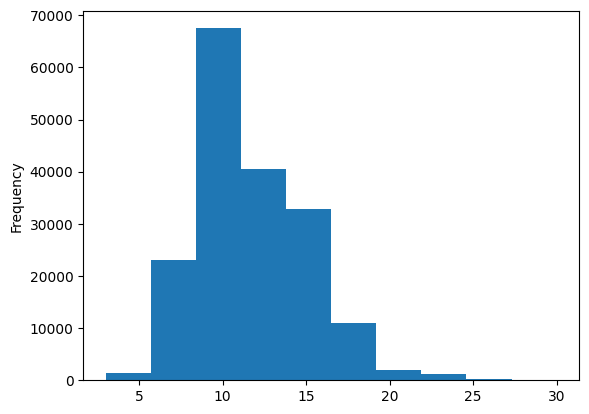

In [ ]:
# Let's check the length of different lines
train_df.total_lines.plot.hist()

### Get list of sentences

In [ ]:
# Convert abstrat text lines into lists
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()
print(len(train_sentences), len(val_sentences), len(test_sentences))

180040 30212 30135


In [ ]:
# View the first lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels 

In [ ]:
# One-hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False) # we want a non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))

# check what one-hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encoded labels

In [ ]:
# Extract labels ('target' columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

# Check how the labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments

As usual, we're going to be trying out a bunch of different models and seeing which one works best.

And as always, we're goint to start with a baseline: TF-IDF Multinomial Naive-Bayes classifier.

## Model 0: Getting a baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions using baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:10]

array([4, 1, 3, 2, 2, 2, 2, 2, 4, 4])

### Download helper function script
In the previous module we wrote a function to compare preditciotns across different metrics and rather than reweiting it here, let's download it from our helper function script: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-04-12 17:56:06--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-04-12 17:56:06 (96.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our text data for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([1.6499e+04, 5.6664e+04, 5.2683e+04, 2.9050e+04, 1.3111e+04,
        5.6610e+03, 3.0490e+03, 1.5190e+03, 8.0800e+02, 4.3200e+02,
        2.2600e+02, 1.2800e+02, 7.7000e+01, 3.9000e+01, 3.0000e+01,
        1.5000e+01, 9.0000e+00, 8.0000e+00, 4.0000e+00, 8.0000e+00,
        7.0000e+00, 5.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1.        ,  10.83333333,  20.66666667,  30.5       ,
         40.33333333,  50.16666667,  60.        ,  69.83333333,
         79.66666667,  89.5       ,  99.33333333, 109.16666667,
        119.        , 128.83333333, 138.66666667, 148.5       ,
        158.33333333, 168.16666667, 178.        , 187.83333333,
        197.66666667, 207.5       , 217.33333333, 227.16666667,
        237.        , 246.83333333, 256.66666667, 266.5       ,
        276.33333333, 286.16666667, 296.        ]),
 <BarContainer object of 30 artists>)

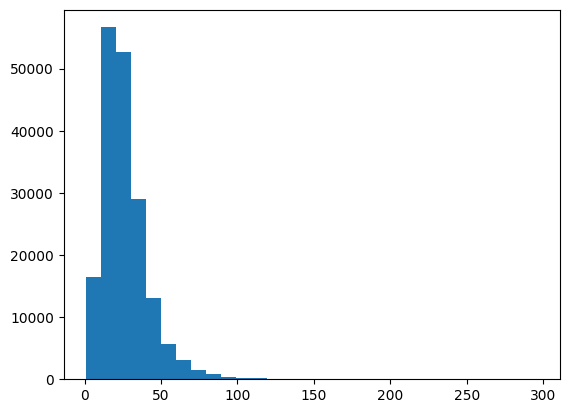

In [ ]:
# What's the distribution like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=30)

In [ ]:
# How long of a sentence length covers 95% of the examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
# Max sequence length in training set
max(sent_lens)

296

### Create text vectorizer layer
We want to get a layer that maps our text from words to numbers. Here's how it can be done...

In [ ]:
# How many words are in our vocab (taken directly from the paper)
max_tokens = 68000

In [ ]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in the vocabulary
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequences

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
import random
target_sequence = random.choice(train_sentences)
print(f"Base sentence: \n{target_sequence}\n")
print(f"Length of text: \n{len(target_sequence.split())}\n")
print(f"Vectorized sentence: \n{text_vectorizer(target_sequence)}")

Base sentence: 
further assessment of this controversial area is required .

Length of text: 
9

Vectorized sentence: 
[ 298  250    4   23 3085  449   20  482    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [ ]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embeedding layer

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128, # different embedding sizes result in a drastical change of paremeter numbers to be trained
                               mask_zero=True, # using masking to handle variable sequence lengths (and save some space)  
                               name="token_embedding")

In [ ]:
# Show an example embeding
print(f"Sentence before vectorization: \n{target_sequence}\n")
print(f"Sentence after vectorization: \n{text_vectorizer(target_sequence)}\n")
print(f"Sentence after embedding: \n{token_embed(text_vectorizer(target_sequence))}\n")
print(f"Embedded sentence shape: \n{token_embed(text_vectorizer(target_sequence)).shape}")

Sentence before vectorization: 
further assessment of this controversial area is required .

Sentence after vectorization: 
[ 298  250    4   23 3085  449   20  482    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]

Sentence after embedding: 
[[ 2.7903888e-02 -2.2493435e-02  3.0781578e-02 ... -4.4025041e-02
  -2.9758656e-02  3.5998944e-02]
 [ 1.7191712e-02  2.9175404e-02  1.7854225e-02 ...  2.4999570e-02
   3.6412250e-02  2.0501446e-02]
 [-2.1527028e-02  2.9638778e-02  7.1547925e-05 ... -3.4484245e-02
  -3.7019573e-02  4.4554662e-02]
 ...
 [-2.7857590e-02 -4.3770637e-02 -1.8566586e-02 ... -1.0731071e-04
   4.8209596e-02 -8.9315660e-03]
 [-2.7857590e-02 -4.3770637e-02 -1.8566586e-02 ... -1.0731071e-04
   4.8209596e-02 -8.9315660e-03]
 [-2.7857590e-02 -4.3770637e-02 -1.8566586e-02 ... -1.0731071e-04
  

## Creating datasets (making sure our data loads as fast as possible)
We're going to setup od data to run as fast as possible with the Tensorflow `tf.data` API, many of the steps are discussed at length in these two resources:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the TensorSliceDatasets and turn them into prefeteched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # no shuffling but the data order is important in this task!
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [ ]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorizing the text (string -> numbers)
token_embeddings = token_embed(text_vectors) # create embeddings
x = layers.Conv1D(filters=64, 
                  kernel_size=5,
                  padding='same',
                  activation='relu')(token_embeddings)
x = layers.GlobalMaxPooling1D()(x) # condense the output of feature vector
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 46s 64ms/step - loss: 0.8343 - accuracy: 0.6864 - val_loss: 0.5927 - val_accuracy: 0.7822
Epoch 2/3
562/562 [==============================] - 9s 16ms/step - loss: 0.5778 - accuracy: 0.7873 - val_loss: 0.5420 - val_accuracy: 0.7975
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.5436 - accuracy: 0.7999 - val_loss: 0.5223 - val_accuracy: 0.8132


In [ ]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5234 - accuracy: 0.8083


[0.5233587622642517, 0.8082550168037415]

In [ ]:
# Make predictions (and our model predicts probability per class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs[:10]

945/945 [==============================] - 2s 2ms/step


array([[6.2681812e-01, 1.2003118e-01, 5.4915110e-03, 2.4100535e-01,
        6.6538854e-03],
       [2.5486833e-01, 5.8006120e-01, 1.8556160e-03, 1.6071978e-01,
        2.4950013e-03],
       [1.4697880e-01, 3.7391356e-03, 1.0413529e-03, 8.4812480e-01,
        1.1595420e-04],
       [2.9963781e-03, 2.6734574e-03, 9.4777238e-01, 2.4026206e-03,
        4.4155169e-02],
       [4.7561745e-03, 3.0853374e-02, 7.1099937e-01, 1.6899668e-03,
        2.5170112e-01],
       [8.4731163e-04, 1.2876507e-03, 4.7314191e-01, 3.2526557e-04,
        5.2439791e-01],
       [1.3841932e-04, 1.7102703e-03, 5.1766557e-01, 6.4486660e-05,
        4.8042127e-01],
       [1.3124819e-03, 1.8402135e-03, 7.3972404e-01, 1.4311492e-03,
        2.5569218e-01],
       [4.1360736e-06, 3.3881498e-04, 2.9495477e-03, 3.9954575e-06,
        9.9670357e-01],
       [1.9760925e-02, 6.4920288e-01, 4.7387999e-02, 1.6075727e-02,
        2.6757246e-01]], dtype=float32)

In [ ]:
# Convert prediction probabilites to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 3, 2, 2, 4, 2, 2, 4, 1])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 80.82549980140341,
 'precision': 0.8066374274206908,
 'recall': 0.8082549980140341,
 'f1': 0.8068148992406133}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature Extraction with pretrained token embeddings
Now let's use pretrained word embeddings from TF Hub, more specifically the Universal Sentence Encoder (so USE in short): https://tfhub.dev/google/universal-sentence-encoder/4

The paper was originally created on GloVe embeddings, however we're going to stick with the lastest USE pretrained model.

In [ ]:
# Download pretrained TF Hub USE 
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name='universal_sentence_encoder')

In [ ]:
# Test our pretrained embedding on random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Base sentence: \n{random_train_sentence}\n")
print(f"Embedded sentence: \n{tf_hub_embedding_layer([random_train_sentence])[0][:30]}\n")
print(f"Length of sentence embedding: {len(tf_hub_embedding_layer([random_train_sentence])[0])}")

Base sentence: 
secondary outcome measures included the psoriasis global assessment ( pga ) score and patients ' quality of life ( qol ) .

Embedded sentence: 
[-0.0513246  -0.04692666 -0.05898448  0.00733655 -0.01069458 -0.00270249
 -0.07784633  0.02768114  0.04049745  0.00901678  0.07823396  0.03412189
 -0.0487976   0.06909035  0.04441252  0.05536492 -0.08046579  0.07783368
  0.0388606   0.02354459  0.04142543  0.05194611  0.06087356  0.03604105
  0.00135366 -0.04699514  0.03973025  0.02183956 -0.00468374  0.01185848]

Length of sentence embedding: 512


### Building and fitting an NLP feature extraction model using a pretrained embeddings from TF Hub

In [ ]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize and embed text of each sequence
x = layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_2 = tf.keras.Model(inputs, outputs, name='model_2_USE_feature_extractor')

# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
# Summary of model_2
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit model_2
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 13s 18ms/step - loss: 0.9188 - accuracy: 0.6492 - val_loss: 0.7986 - val_accuracy: 0.6928
Epoch 2/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7698 - accuracy: 0.7019 - val_loss: 0.7573 - val_accuracy: 0.7061
Epoch 3/3
562/562 [==============================] - 10s 17ms/step - loss: 0.7534 - accuracy: 0.7124 - val_loss: 0.7402 - val_accuracy: 0.7118


In [ ]:
# Evaluate it on the whole dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 12s 13ms/step - loss: 0.7421 - accuracy: 0.7133


[0.7421233057975769, 0.7133258581161499]

In [ ]:
# Make predictions
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs[:10]

945/945 [==============================] - 12s 12ms/step


array([[4.34718370e-01, 3.58171046e-01, 2.34496733e-03, 1.96369991e-01,
        8.39558709e-03],
       [3.61088634e-01, 4.61149246e-01, 3.83472419e-03, 1.70621142e-01,
        3.30618792e-03],
       [2.32705221e-01, 1.41089603e-01, 1.70786474e-02, 5.67328215e-01,
        4.17982452e-02],
       [1.47473430e-02, 4.97636013e-02, 8.03133130e-01, 9.85373836e-03,
        1.22502215e-01],
       [3.22786011e-02, 2.28100687e-01, 2.40274504e-01, 1.33364908e-02,
        4.86009747e-01],
       [1.09894271e-03, 2.80917273e-03, 7.04329908e-01, 2.08995334e-04,
        2.91552961e-01],
       [2.11837376e-03, 2.86315056e-03, 6.74150765e-01, 1.46882329e-03,
        3.19398940e-01],
       [5.03967609e-03, 2.68512759e-02, 4.84492749e-01, 1.71451957e-03,
        4.81901765e-01],
       [6.72682887e-04, 6.50089188e-03, 2.25003827e-02, 1.16038800e-03,
        9.69165623e-01],
       [1.34376749e-01, 6.98153853e-01, 2.11733468e-02, 7.90451244e-02,
        6.72510341e-02]], dtype=float32)

In [ ]:
# Convert the prediction probabilities
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 3, 2, 4, 2, 2, 2, 4, 1])>

In [ ]:
# Calculate results
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

{'accuracy': 71.33258307957104,
 'precision': 0.7139925250242133,
 'recall': 0.7133258307957103,
 'f1': 0.7103547538271577}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 3: Conv1D with character embeddings
The paper which we're replicating states they used a combination of token and character-level embeddings.

Previously we've token-level embeddings but we'll need to do similar steps for charecters if we want to use char-level embeddings.

### Create a character-level tokenizer

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non character-level sequence into characters
split_chars(random_train_sentence)

"s e c o n d a r y   o u t c o m e   m e a s u r e s   i n c l u d e d   t h e   p s o r i a s i s   g l o b a l   a s s e s s m e n t   (   p g a   )   s c o r e   a n d   p a t i e n t s   '   q u a l i t y   o f   l i f e   (   q o l   )   ."

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [ ]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([2.2108e+04, 7.0583e+04, 5.3952e+04, 2.2391e+04, 7.4540e+03,
        2.2350e+03, 8.0200e+02, 2.8700e+02, 1.1800e+02, 4.9000e+01,
        2.9000e+01, 1.3000e+01, 8.0000e+00, 5.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 7.02500e+01, 1.39500e+02, 2.08750e+02, 2.78000e+02,
        3.47250e+02, 4.16500e+02, 4.85750e+02, 5.55000e+02, 6.24250e+02,
        6.93500e+02, 7.62750e+02, 8.32000e+02, 9.01250e+02, 9.70500e+02,
        1.03975e+03, 1.10900e+03, 1.17825e+03, 1.24750e+03, 1.31675e+03,
        1.38600e+03]),
 <BarContainer object of 20 artists>)

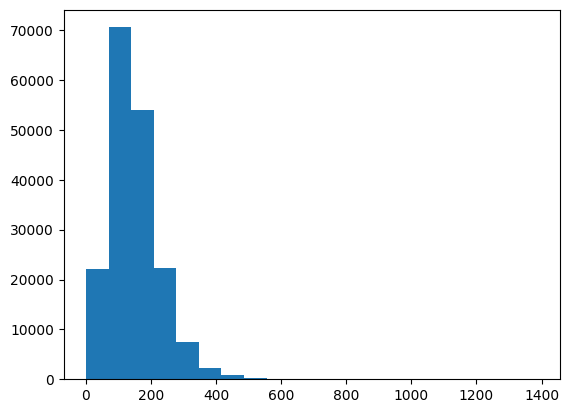

In [ ]:
# Check the distribution of our sequences on character level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=20)

In [ ]:
# Find what character length covers 95% of the sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet, len(alphabet)

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 68)

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV -> out of vocabulary, '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize=None, # None -> punctuation will be left
                                    name='char_vectorizer')

In [ ]:
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different chars: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different chars: 57
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['|', '"', ']', '\\', '[']


In [ ]:
# Test character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text: \n{random_train_chars}\n")
print(f"Length of random_train_chars: \n{len(random_train_chars.split())}\n")
vecorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorized, charified text: \n{vecorized_chars}")
print(f"Length of vectorized random_train_chars: \n{len(vecorized_chars[0])}")

Charified text: 
i n   @   p a t i e n t s   (   @   )   t h e   s u f f i c i e n t   d i a g n o s t i c   q u a l i t y   (   s c o r e   @ - @   )   i n   a o r t a   ,   i l i a c   a n d   f e m o r a l   a r t e r i e s   w a s   d e t e r m i n e d   .

Length of random_train_chars: 
99

Vectorized, charified text: 
[[ 4  6 19 14  5  3  4  2  6  3  9 28 19 27  3 13  2  9 16 17 17  4 11  4
   2  6  3 10  4  5 18  6  7  9  3  4 11 34 16  5 12  4  3 20 28  9 11  7
   8  2 19 26 19 27  4  6  5  7  8  3  5 24  4 12  4  5 11  5  6 10 17  2
  15  7  8  5 12  5  8  3  2  8  4  2  9 21  5  9 10  2  3  2  8 15  4  6
   2 10 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0 

### Creating character-level embedding

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different characters
                              output_dim=25, # size of the char embedding in the paper
                              mask_zero=True,
                              name='char_embed')

In [ ]:
# Test out char embedding layer
print(f"Charified text: \n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded, vectorizer and charified text: \n{char_embed_example}\n")
print(f"Character embedding shape: \n{char_embed_example.shape}")

Charified text: 
i n   @   p a t i e n t s   (   @   )   t h e   s u f f i c i e n t   d i a g n o s t i c   q u a l i t y   (   s c o r e   @ - @   )   i n   a o r t a   ,   i l i a c   a n d   f e m o r a l   a r t e r i e s   w a s   d e t e r m i n e d   .

Embedded, vectorizer and charified text: 
[[[ 0.03522168 -0.00233636 -0.03465891 ... -0.01705651 -0.04294989
    0.0459995 ]
  [-0.01448804 -0.0217992  -0.00065484 ...  0.03372062  0.03878549
    0.01753714]
  [-0.02096984  0.03569278  0.02161905 ...  0.02774009  0.04743123
   -0.04637045]
  ...
  [-0.01555648 -0.04542222  0.00112681 ...  0.02932335 -0.03283452
    0.02653069]
  [-0.01555648 -0.04542222  0.00112681 ...  0.02932335 -0.03283452
    0.02653069]
  [-0.01555648 -0.04542222  0.00112681 ...  0.02932335 -0.03283452
    0.02653069]]]

Character embedding shape: 
(1, 290, 25)


### Building a Conv1D model to fit on character embeddings

In [ ]:
# Model 3 - Conv1D with char level embedding
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(filters=64,
                  kernel_size=10,
                  padding='same',
                  activation='relu')(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

# Create a model
model_3 = tf.keras.Model(inputs, 
                         outputs, 
                         name='model_3_conv1D_char_embeddings')

# Check the summary
model_3.summary()

# Compile the model
model_3.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

Model: "model_3_conv1D_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1425      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           16064     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 

In [ ]:
# Create char-level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 8s 11ms/step - loss: 1.1299 - accuracy: 0.5518 - val_loss: 0.9149 - val_accuracy: 0.6396
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 0.8585 - accuracy: 0.6606 - val_loss: 0.8065 - val_accuracy: 0.6925
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.7787 - accuracy: 0.6985 - val_loss: 0.7387 - val_accuracy: 0.7221


In [ ]:
# Evaluate the model
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.7428 - accuracy: 0.7107


[0.7428066730499268, 0.7107440829277039]

In [ ]:
# Make predictions with character level only
model_3_pred_probs = model_3.predict(val_char_dataset)
print(f"Preds shape: \n{model_3_pred_probs.shape}")
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
print(f"Exemplary preds: \n{model_3_preds[:10]}")

945/945 [==============================] - 3s 4ms/step
Preds shape: 
(30212, 5)
Exemplary preds: 
[1 1 1 2 2 2 2 1 4 2]


In [ ]:
# Calculate the results for Conv1D chars only
model_3_results = calculate_results(val_labels_encoded,
                                    model_3_preds)
model_3_results

{'accuracy': 71.07440752019065,
 'precision': 0.7100520971333378,
 'recall': 0.7107440752019065,
 'f1': 0.702719290646217}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid style model)

1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level embedding model (simiar to `model_3` but with slight adjustment)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3 (simiar to Figure 1 and section 4.2 of paper https://arxiv.org/pdf/1612.05251.pdf)
5. Construct a model which takes token and character-level sequences as inputs and produces sequence label probaiblities as output.

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM shown in Figure 1 of paper
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout, discussed section 4.2 of paper
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name='token_char_embeddigns')

In [ ]:
# Check the summary
model_4.summary()

Model: "token_char_embeddigns"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_input

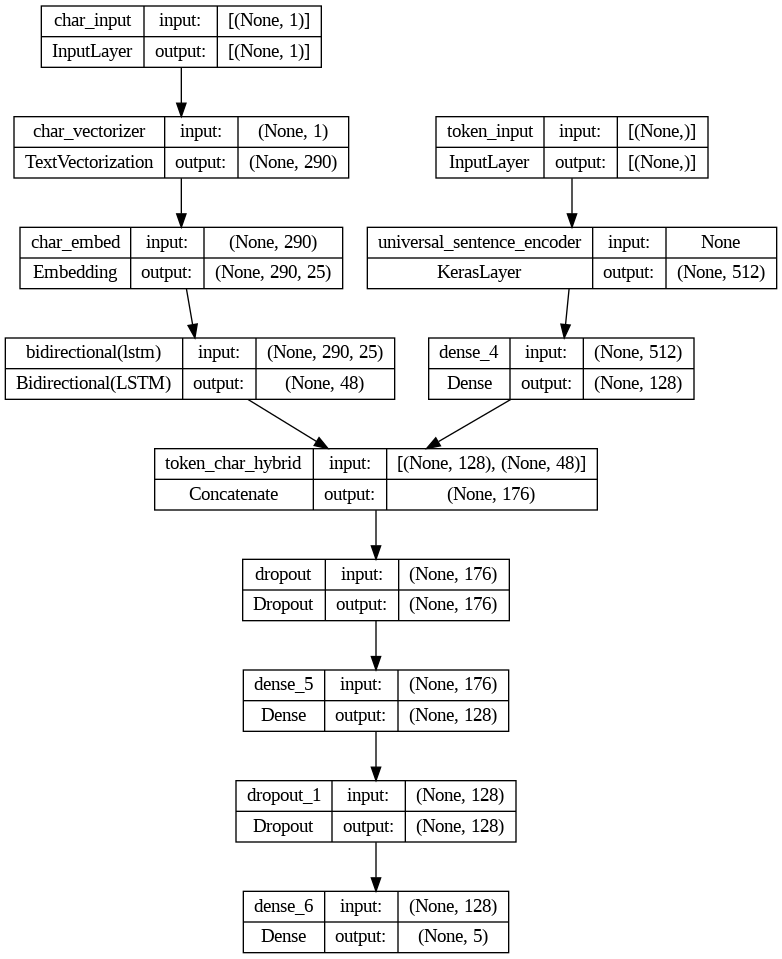

In [ ]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
# Compile token char model
model_4.compile(loss='categorical_crossentropy',
                optimizer='adam', # section 4.2 of paper says they use SGD
                metrics=['accuracy'])

### Combining token and character data into tf.data Dataset

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make the data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) #combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Repeat the above steps for validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make the data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) #combine data and labels
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [ ]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 41s 52ms/step - loss: 0.9747 - accuracy: 0.6074 - val_loss: 0.7657 - val_accuracy: 0.7018
Epoch 2/3
562/562 [==============================] - 26s 46ms/step - loss: 0.7872 - accuracy: 0.6950 - val_loss: 0.7135 - val_accuracy: 0.7297
Epoch 3/3
562/562 [==============================] - 26s 46ms/step - loss: 0.7572 - accuracy: 0.7129 - val_loss: 0.6783 - val_accuracy: 0.7434


In [ ]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 25s 26ms/step - loss: 0.6782 - accuracy: 0.7416


[0.6781820058822632, 0.7416258454322815]

In [ ]:
# Make predictions on hybrid model
model_4_pred_probs = model_4.predict(val_char_token_dataset)
print(f"Probs shape: {model_4_pred_probs.shape}")
print(f"Exemplary probs: {model_4_pred_probs[0]}")

945/945 [==============================] - 22s 23ms/step
Probs shape: (30212, 5)
Exemplary probs: [0.42979476 0.36387983 0.00381923 0.19778402 0.0047222 ]


In [ ]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 3, 2, 2, 2, 2, 2, 4, 1])>

In [ ]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(val_labels_encoded,
                                    model_4_preds)
model_4_results

{'accuracy': 74.16258440354827,
 'precision': 0.7431217467177468,
 'recall': 0.7416258440354826,
 'f1': 0.7387268542561224}

In [ ]:
model_1_results

{'accuracy': 80.82549980140341,
 'precision': 0.8066374274206908,
 'recall': 0.8082549980140341,
 'f1': 0.8068148992406133}

## Model 5: Transfer learning with pretrained token embeddings + token embeddings + positional embeddings

> **NOTE:** Ane engineered features used to train a model need to be available at test time. In our case: line numbers and total lines are available.

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


### Create positional embeddings

In [ ]:
# How many different line numbers are there?
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

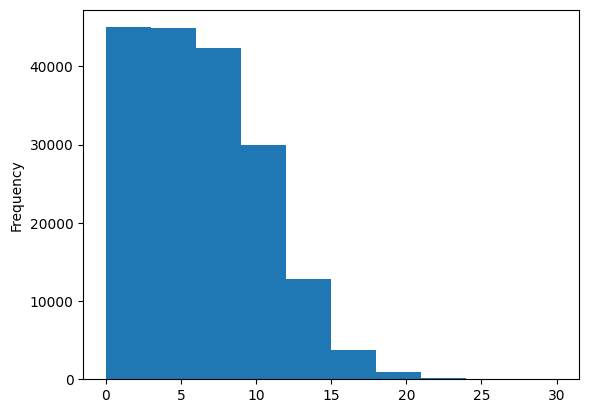

In [ ]:
# Check the distribution of line_number column
train_df.line_number.plot.hist()

In [130]:
# Use TensorFlow to create one-hot encoded tensors of our line_number column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

train_line_numbers_one_hot[:15], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(15, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

Now we've encoded our line numbers feature, let's do the same for our total lines feature...

In [ ]:
# How many different lines are there?
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

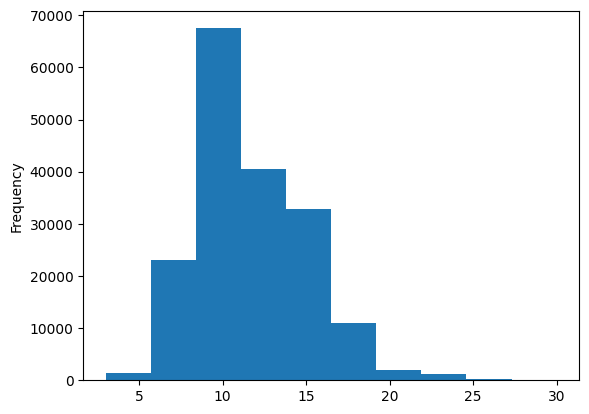

In [ ]:
# Check the distribution of total lines
train_df.total_lines.plot.hist()

In [ ]:
# Check the coverage of a 'total_lines' value of 20
np.percentile(train_df['total_lines'], 98)

20.0

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors 
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

train_total_lines_one_hot[:15], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(15, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the 'line_number' feature
4. Create a model for the 'total_lines' feature
5. Combine the outputs of 1 & 2 using `tf.keras.layers.Concatenate`
6. Combine the outputs of 3, 4 & 5 using `tf.keras.layers.Concatenate`
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and the outputs of 7 into a `tf.keras.Model`

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name='line_number_input')
line_number_outputs = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=line_number_outputs)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name='total_lines_input')
total_lines_outputs = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=total_lines_outputs)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name='char_token_hybrid_embedding')([token_model.output,
                                                                              char_model.output])
combined_dense = layers.Dense(256, activation='relu')(combined_embeddings)
combined_dropout = layers.Dropout(0.5)(combined_dense)

# 6. Combine positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name='char_token_positional_embedding')([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 combined_dropout])

# 7. Create output layer
output_layer = layers.Dense(5, activation='softmax', name='output_layer')(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name='model_5_tribrid_embedding_model')

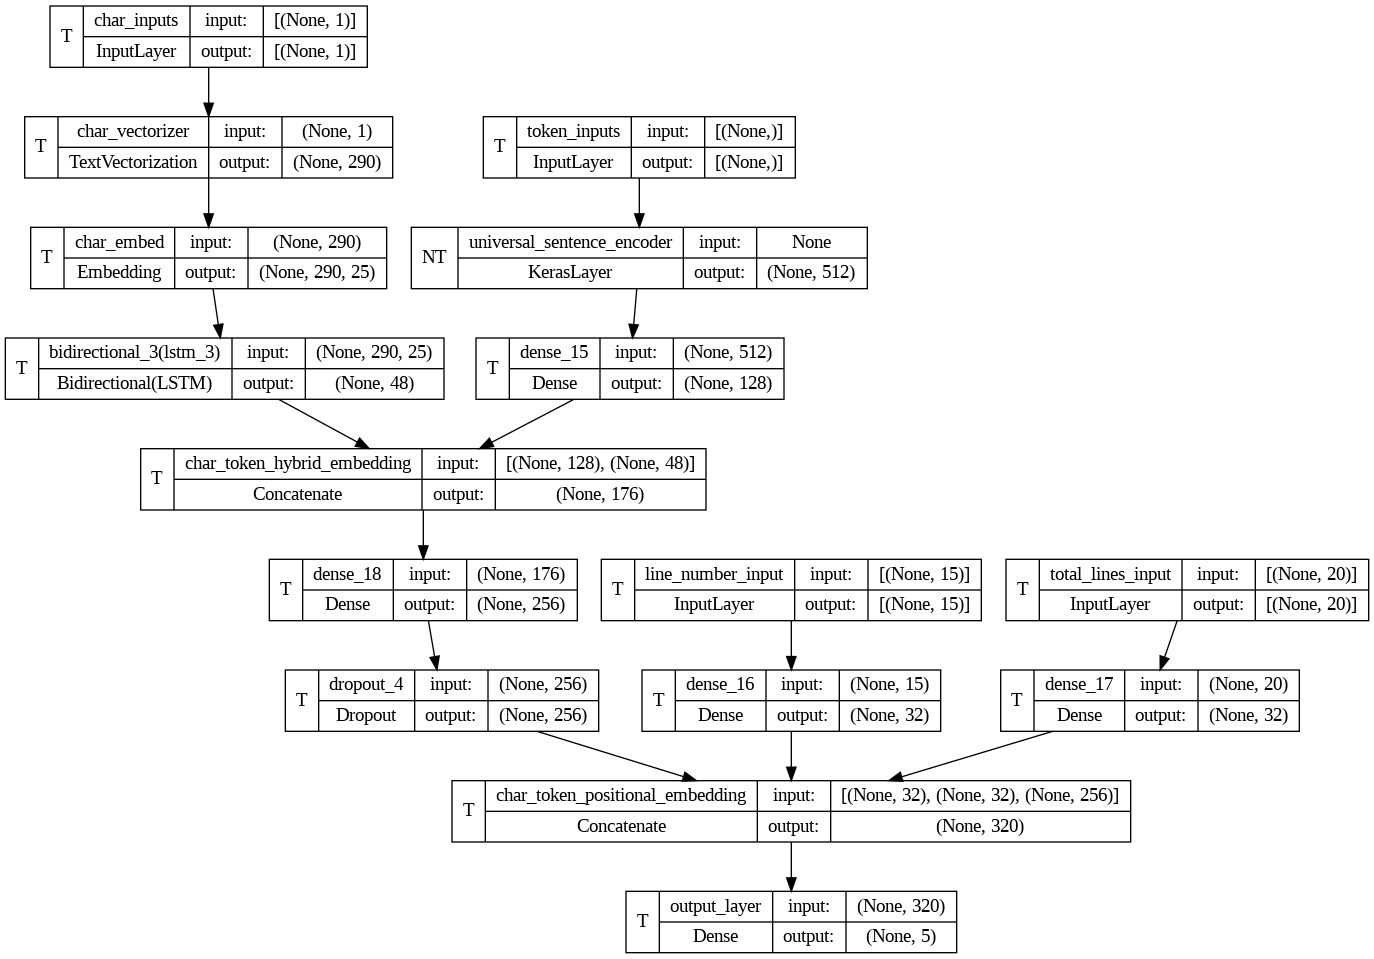

In [ ]:
# Plot the architecture of the model
plot_model(model_5, 
           show_shapes=True,
           show_trainable=True)

In [ ]:
# Check the summary
model_5.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

In [129]:
# Compile token-char-positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # help to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### Create tribrid embedding datasets using tf.data

In [131]:
# Create training and validation datasets with all 4 kinds of input data
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, 
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above for validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot, 
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [135]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making predictions on tribrid model

In [136]:
# Fit the tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 46s 57ms/step - loss: 1.0912 - accuracy: 0.7256 - val_loss: 0.9795 - val_accuracy: 0.8085
Epoch 2/3
562/562 [==============================] - 30s 53ms/step - loss: 0.9594 - accuracy: 0.8198 - val_loss: 0.9443 - val_accuracy: 0.8358
Epoch 3/3
562/562 [==============================] - 26s 46ms/step - loss: 0.9499 - accuracy: 0.8253 - val_loss: 0.9328 - val_accuracy: 0.8384


In [137]:
# Evaluate the model
model_5.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 36s 38ms/step - loss: 0.9296 - accuracy: 0.8401


[0.9295927882194519, 0.840096652507782]

In [138]:
# Make predictions
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_pred_probs.shape

945/945 [==============================] - 26s 24ms/step


(30212, 5)

In [139]:
# Convert probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [140]:
# Calculate the results
model_5_results = calculate_results(val_labels_encoded,
                                    model_5_preds)
model_5_results

{'accuracy': 84.00966503376142,
 'precision': 0.8385581492854093,
 'recall': 0.8400966503376142,
 'f1': 0.8384196687864471}